# The new quaternion functions
With calcMadgwick, we can add Madgwick_x, Madgwick_y, Madgwick_z, Madgwick_w to the dataset
with calib madgwick we can calculate the transforming quaternion
with madgwickToMocap we can add MAD_to_MOC_x, MAD_to_MOC_y, MAD_to_MOC_z, MAD_to_MOC_w
with mocapToMadgwick we can add MOC_to_MAD_x, MOC_to_MAD_y, MOC_to_MAD_z, MOC_to_MAD_w

Testing

In [1]:
# Imports
import Transformer
from tensorflow.keras.optimizers import Adam

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, LastDimensionNormalizer, Batcher
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
from Quaternion_functions import quaternion_to_euler_angle_vectorized1
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

import ahrs

In [2]:
folder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható

# load in the full measurement sequence
d = DataStream(folder)

# Slice the second part for Calibration
d_calib = deepcopy(d)
d_calib.keepData(2600, 18500)

# Calibrate the rest of the measurement (Training, Validation and Test set also)
d.calibrateMag(d_calib)

# Add extra features to the collective database here
d.addFeature(['diff_Timestamp'])

# Apply filter for the rest of the measurement (Training, Validation and Test set also)
d.filterData(31, 'bartlett', [1, 2, 3]) # filter Acc
d.filterData(31, 'bartlett', [4, 5, 6]) # filter Gyro
d.filterData(31, 'bartlett', [7, 8, 9]) # filter Mag

# Slice the first part for Initialization (Calculate the Rotation Qoaternion betwwen MoCap and Sensor coordinate system)
d_stand = deepcopy(d)
d_stand.keepData(0,500)

d.calibMadgwick(d_stand, axis= 'MAD')# now we have to give the axis as well
#this indicates: MAD: MAD->MOC , MOC: MOC-> MAD


# Slice the third part of the measurement for Training dataset
d_train = deepcopy(d)
d_train.keepData(18600, 42100)
d_train.calcMadgwick() 
# If further filtering is needed apply here for only on Training data

# Slice the fourth part of the measurement for Validation dataset
d_valid = deepcopy(d)
d_valid.keepData(43000, 51000)
d_valid.calcMadgwick()
# If further filtering is needed apply here for only on Validation data

# Slice the fifth part of the measurement for Test dataset
d_test = deepcopy(d)
d_test.keepData(51500, 61720)
d_test.calcMadgwick() # bele rakja a sima ahrs-sel számolt madgwickot az adatsorba
# If further filtering is needed apply here for only on Test data

d.calcMadgwick()

In [3]:
# the results:

d_train.showHeader()
d_valid.showHeader()
d_test.showHeader()
d.showHeader()

#21-22-23-24 will be the orginial madgwick values

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Mad

In [4]:
#lets test the madgwickToMocap function

d.madgwickToMocap([21,22,23,24])
d_test.madgwickToMocap([21,22,23,24])
d_valid.madgwickToMocap([21,22,23,24])
d_train.madgwickToMocap([21,22,23,24])

In [5]:
#lets see the results

d_train.showHeader()
d_test.showHeader()
d_valid.showHeader()
d.showHeader()

#25-26-27-28 is now the mocap quaternion transformed from the madgwick quaternion

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
25 - Mad_to_MOC_X
26 - Mad_to_MOC_Y
27 - Mad_to_MOC_Z
28 - Mad_to_MOC_W
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
25 - Mad_to_MOC_X
26 - Mad_to_MOC_Y
27 - Mad_to_MOC_Z
28 - Mad_to_MOC_W
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG

Lets check it out on graphs

<function matplotlib.pyplot.show(*args, **kw)>

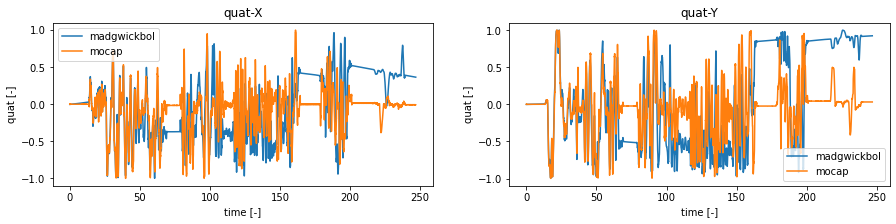

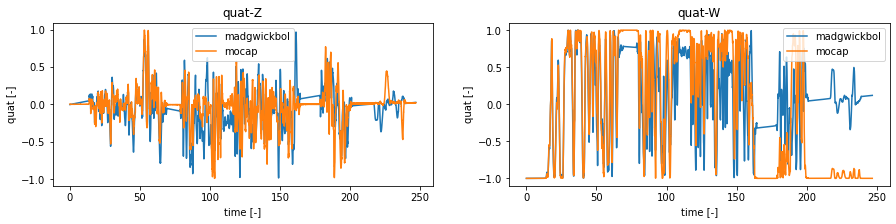

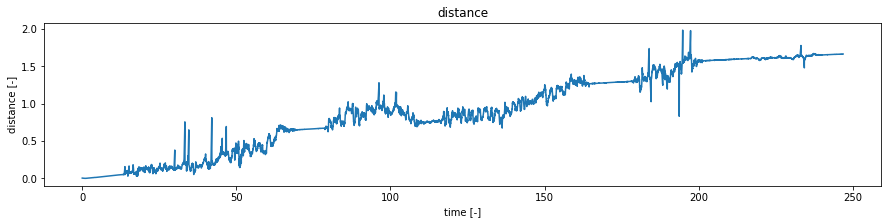

In [6]:
#The whole d

#MocapQ = d_train.data[:,13:17]
#MAD_to_MOC = d_train.data[:,25:29]

time = np.zeros(len(d.data))
for i in range(len(d.data)):
    time[i] = 0.004*i
    
distance = distance_check(d.data[:,13:17], d.data[:,25:29], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d.data[:,25],label='madgwickbol')
plt.plot(time,d.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d.data[:,26],label='madgwickbol')
plt.plot(time,d.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d.data[:,27],label='madgwickbol')
plt.plot(time,d.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d.data[:,28],label='madgwickbol')
plt.plot(time,d.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show


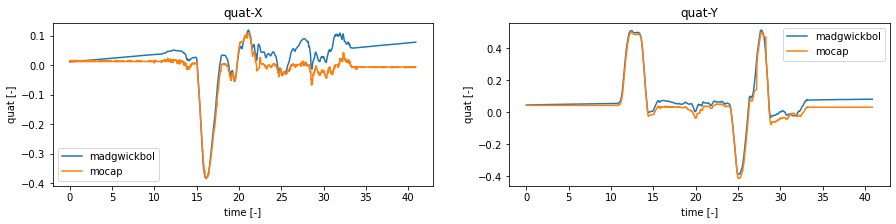

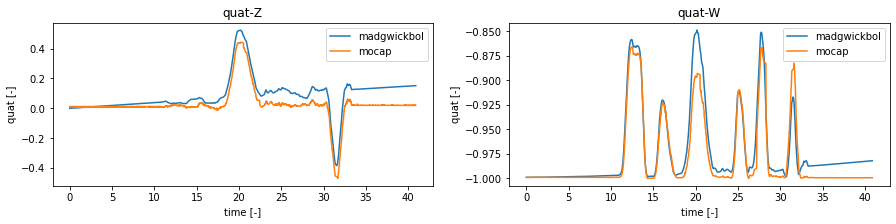

In [7]:
#test data

#MocapQ = d_train.data[:,13:17]
#MAD_to_MOC = d_train.data[:,25:29]

time = np.zeros(len(d_test.data))
for i in range(len(d_test.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_test.data[:,13:17], d_test.data[:,25:29], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_test.data[:,25],label='madgwickbol')
plt.plot(time,d_test.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_test.data[:,26],label='madgwickbol')
plt.plot(time,d_test.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_test.data[:,27],label='madgwickbol')
plt.plot(time,d_test.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_test.data[:,28],label='madgwickbol')
plt.plot(time,d_test.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()


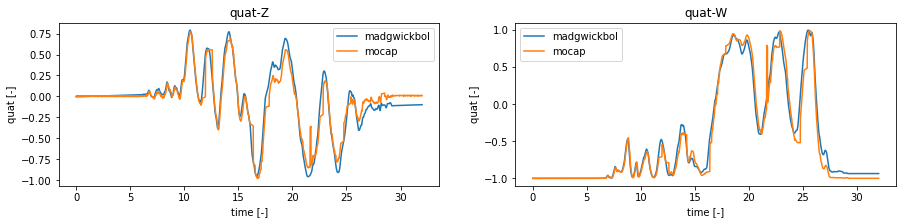

In [8]:
# valid data

#MocapQ = d_train.data[:,13:17]
#MAD_to_MOC = d_train.data[:,25:29]

time = np.zeros(len(d_valid.data))
for i in range(len(d_valid.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_valid.data[:,13:17], d_valid.data[:,25:29], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_valid.data[:,25],label='madgwickbol')
plt.plot(time,d_valid.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_valid.data[:,26],label='madgwickbol')
plt.plot(time,d_valid.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_valid.data[:,27],label='madgwickbol')
plt.plot(time,d_valid.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_valid.data[:,28],label='madgwickbol')
plt.plot(time,d_valid.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()


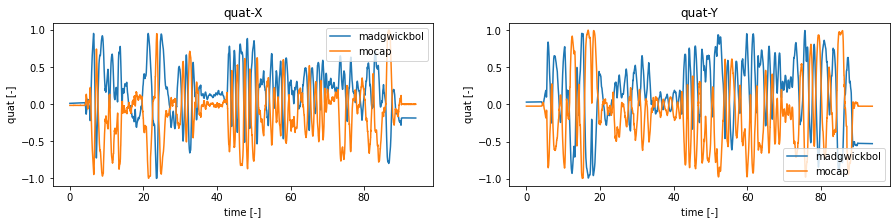

In [9]:
#train data

#MocapQ = d_train.data[:,13:17]
#MAD_to_MOC = d_train.data[:,25:29]

time = np.zeros(len(d_train.data))
for i in range(len(d_train.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_train.data[:,13:17], d_train.data[:,25:29], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_train.data[:,25],label='madgwickbol')
plt.plot(time,d_train.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_train.data[:,26],label='madgwickbol')
plt.plot(time,d_train.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_train.data[:,27],label='madgwickbol')
plt.plot(time,d_train.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_train.data[:,28],label='madgwickbol')
plt.plot(time,d_train.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()


### We can see that the algorith seems to work, but we need to adknowledge some things:
- The madgwick function from the ahrs repo, has a constant shift which can be seen on the graphs from the whole d, this may be the result of the very low gain but i am not sure of that
- The result of the madgwick function is a bit unpredictable, as we can see on the results of the train data. sometimes it uses the negative pair of the quaternions, I guess it works according to the given data, but I don't how could we make this predictable
- another problem with the unpredictability of the madgwick from the ahrs is this:

In [30]:
#lets check out two different data-s
folder_calib = str("../logs/20201002_10_17_42/")  # Y up - Calib for Magneto
folder_test  = str("../logs/20201002_10_19_33/")  # Y up - General Test

e = DataStream(folder_test)
f = DataStream(folder_calib)

e.calibrateMag(f)
e.addFeature(['diff_Timestamp'])
e.filterData(31, 'hanning', [1, 2, 3]) # filter Acc
e.filterData(31, 'hanning', [4, 5, 6]) # filter Gyro
e.filterData(31, 'hanning', [7, 8, 9]) # filter Mag

#now we have e

folder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható

g = DataStream(folder)

g_calib = deepcopy(g)
g_calib.keepData(2600, 18500)

g.calibrateMag(g_calib)
g.addFeature(['diff_Timestamp'])
# Apply filter for the rest of the measurement (Training, Validation and Test set also)
g.filterData(31, 'bartlett', [1, 2, 3]) # filter Acc
g.filterData(31, 'bartlett', [4, 5, 6]) # filter Gyro
g.filterData(31, 'bartlett', [7, 8, 9]) # filter Mag

# Slice the fifth part of the measurement for Test dataset
g_test = deepcopy(g)
g_test.keepData(51500, 61720)

#and g_stand

In [11]:
Acc_e    = e.data[:,1:4]
Gyro_e   = e.data[:,4:7]
Mag_e    = e.data[:,7:10]
MocapQ_e = e.data[:,13:17]

Acc_g    = g_test.data[:,1:4]
Gyro_g   = g_test.data[:,4:7]
Mag_g    = g_test.data[:,7:10]
MocapQ_g = g_test.data[:,13:17]

MadgwickQ shape: (3471, 4)


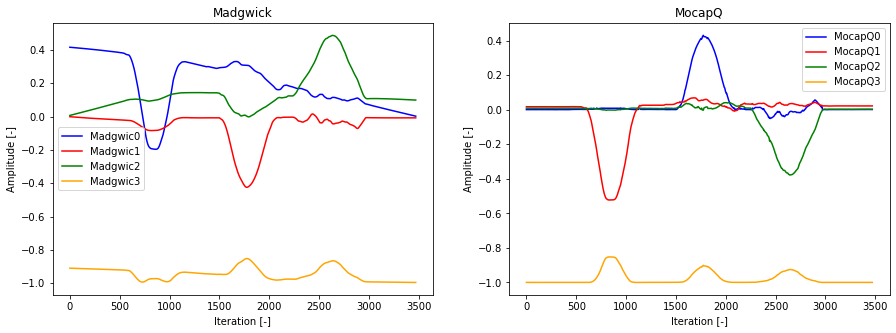

MadgwickQ shape: (10220, 4)


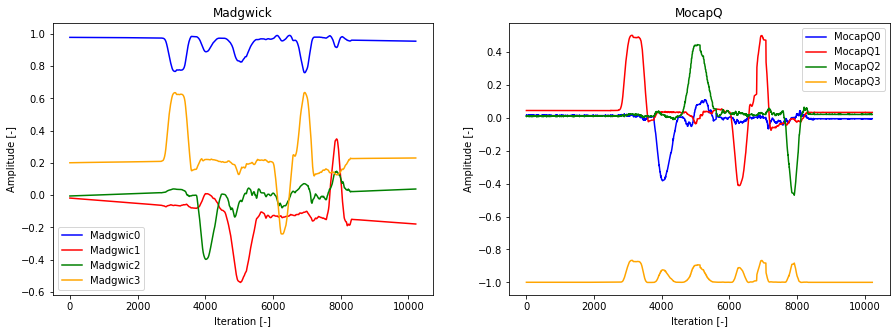

In [31]:
#q_init = [0.0, 0.0, 1.0, 0.0] 
# defining the madgwick vector

MadgwickE = ahrs.filters.Madgwick(acc=Acc_e*9.8077, gyr=Gyro_e/57.3, mag=Mag_e*10, gain=0.041, Dt=0.004) #q0=q_init #az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickE.Q.shape))                        #gain = 0.000001
                                                                          #0.041 may be better
plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickE.Q[:,0], color='blue', label='Madgwic0')
plt.plot(MadgwickE.Q[:,1], color='red', label='Madgwic1')
plt.plot(MadgwickE.Q[:,2], color='green', label='Madgwic2')
plt.plot(MadgwickE.Q[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_e[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ_e[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ_e[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ_e[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

MadgwickG = ahrs.filters.Madgwick(acc=Acc_g*9.8077, gyr=Gyro_g/57.3, mag=Mag_g*10, gain=0.000001, Dt=0.004) #q0=q_init #az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickG.Q.shape)) 

plt.figure(4, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickG.Q[:,0], color='blue', label='Madgwic0')
plt.plot(MadgwickG.Q[:,1], color='red', label='Madgwic1')
plt.plot(MadgwickG.Q[:,2], color='green', label='Madgwic2')
plt.plot(MadgwickG.Q[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_g[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ_g[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ_g[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ_g[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

In [13]:
#the actual problem is the at first the W quaterrnion is at the forth places as in the mocap
#but the second time, the w quaternionis at the first place, and I dont know why the functon does that

In [14]:
#back to the topic
# the train data could be good if I calib the madgwick with that data:

In [15]:
d_train.calibMadgwick(d_stand, axis= 'MOC')
d_train.calibMadgwick(d_train, axis= 'MAD')

#with this it should work, but this takes a lot of time:

In [16]:
d_train.madgwickToMocap([21,22,23,24])

In [17]:
#we can see that the two trnasformation quats are differenet:
print(d_train.transform_quat)
print(d_test.transform_quat)

[0.90081824 0.13844845 0.32532917 0.12036981]
[-0.9874163   0.01643752 -0.15648479 -0.01566752]


In [18]:
d_train.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
25 - Mad_to_MOC_X
26 - Mad_to_MOC_Y
27 - Mad_to_MOC_Z
28 - Mad_to_MOC_W
29 - Mad_to_MOC_X
30 - Mad_to_MOC_Y
31 - Mad_to_MOC_Z
32 - Mad_to_MOC_W


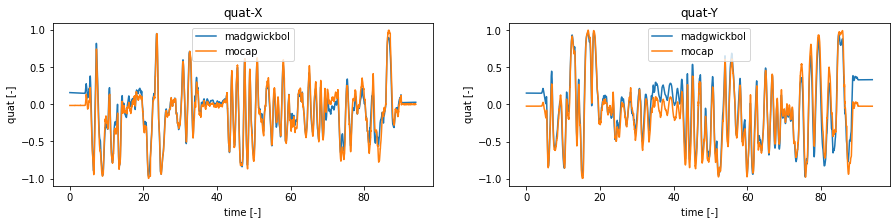

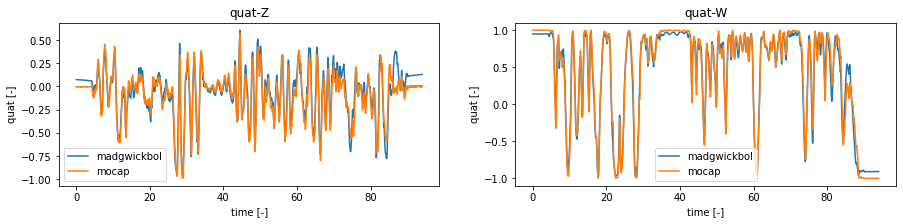

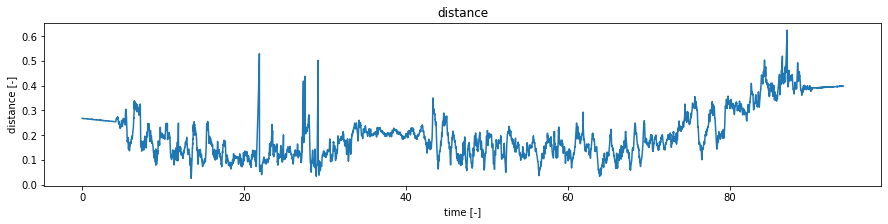

In [19]:
#train data

#MocapQ = d_train.data[:,13:17]
#MAD_to_MOC = d_train.data[:,25:29]

time = np.zeros(len(d_train.data))
for i in range(len(d_train.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_train.data[:,13:17], d_train.data[:,29:33], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_train.data[:,29],label='madgwickbol')
plt.plot(time,d_train.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_train.data[:,30],label='madgwickbol')
plt.plot(time,d_train.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_train.data[:,31],label='madgwickbol')
plt.plot(time,d_train.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_train.data[:,32],label='madgwickbol')
plt.plot(time,d_train.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

In [20]:
#lets test the madgwickToMocap function too:

In [21]:
d.calibMadgwick(d_stand, axis= 'MOC')
d_train.calibMadgwick(d_stand, axis= 'MOC')
d_valid.calibMadgwick(d_stand, axis= 'MOC')
d_test.calibMadgwick(d_stand, axis= 'MOC')

In [22]:
d_test.mocapToMadgwick([21,22,23,24])
d_valid.mocapToMadgwick([21,22,23,24])
d.mocapToMadgwick([21,22,23,24])

In [23]:
d_train.mocapToMadgwick([21,22,23,24])

In [24]:
d_train.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W
25 - Mad_to_MOC_X
26 - Mad_to_MOC_Y
27 - Mad_to_MOC_Z
28 - Mad_to_MOC_W
29 - Mad_to_MOC_X
30 - Mad_to_MOC_Y
31 - Mad_to_MOC_Z
32 - Mad_to_MOC_W
33 - MOC_to_MAD_X
34 - MOC_to_MAD_Y
35 - MOC_to_MAD_Z
36 - MOC_to_MAD_W


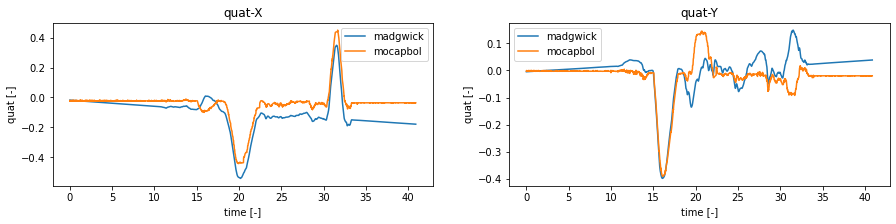

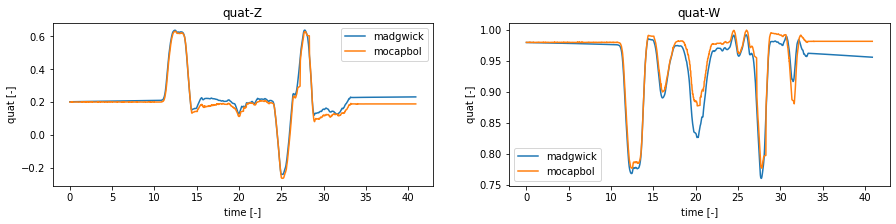

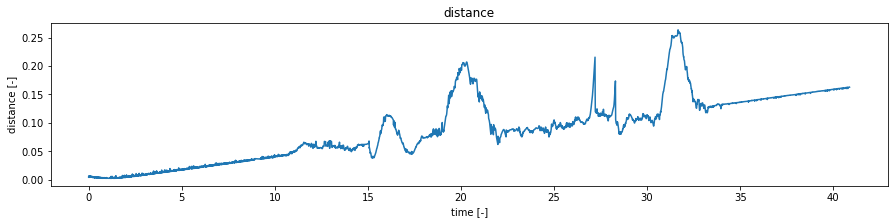

In [25]:
time = np.zeros(len(d_test.data))
for i in range(len(d_test.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_test.data[:,21:25], d_test.data[:,29:33], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_test.data[:,21],label='madgwick')
plt.plot(time,d_test.data[:,29],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_test.data[:,22],label='madgwick')
plt.plot(time,d_test.data[:,30],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_test.data[:,23],label='madgwick')
plt.plot(time,d_test.data[:,31],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_test.data[:,24],label='madgwick')
plt.plot(time,d_test.data[:,32],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

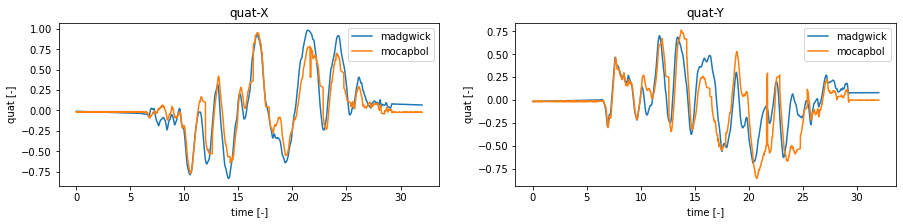

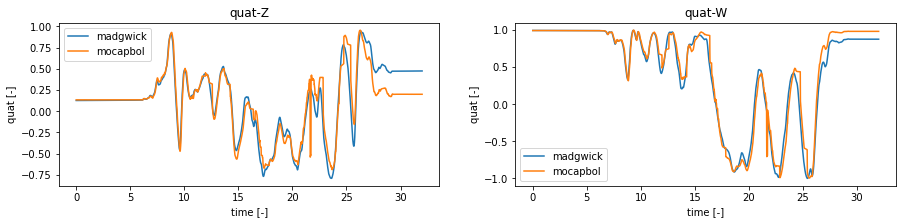

In [26]:
time = np.zeros(len(d_valid.data))
for i in range(len(d_valid.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_valid.data[:,21:25], d_valid.data[:,29:33], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_valid.data[:,21],label='madgwick')
plt.plot(time,d_valid.data[:,29],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_valid.data[:,22],label='madgwick')
plt.plot(time,d_valid.data[:,30],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_valid.data[:,23],label='madgwick')
plt.plot(time,d_valid.data[:,31],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_valid.data[:,24],label='madgwick')
plt.plot(time,d_valid.data[:,32],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

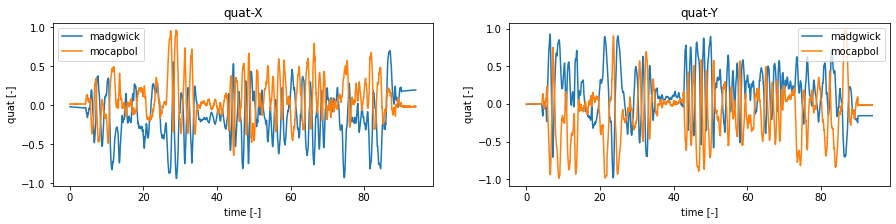

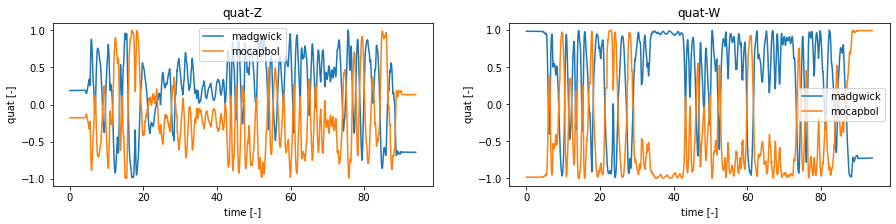

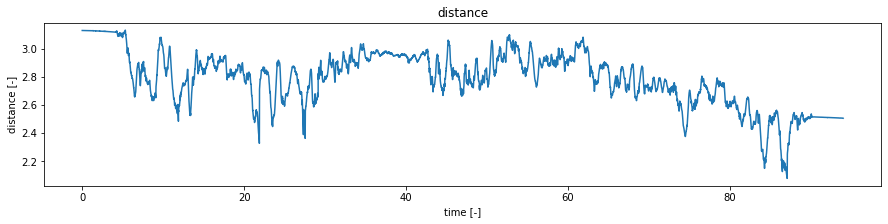

In [27]:
time = np.zeros(len(d_train.data))
for i in range(len(d_train.data)):
    time[i] = 0.004*i
    
distance = distance_check(d_train.data[:,21:25], d_train.data[:,33:37], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d_train.data[:,21],label='madgwick')
plt.plot(time,d_train.data[:,33],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d_train.data[:,22],label='madgwick')
plt.plot(time,d_train.data[:,34],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d_train.data[:,23],label='madgwick')
plt.plot(time,d_train.data[:,35],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d_train.data[:,24],label='madgwick')
plt.plot(time,d_train.data[:,36],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

In [28]:
# the same problem here

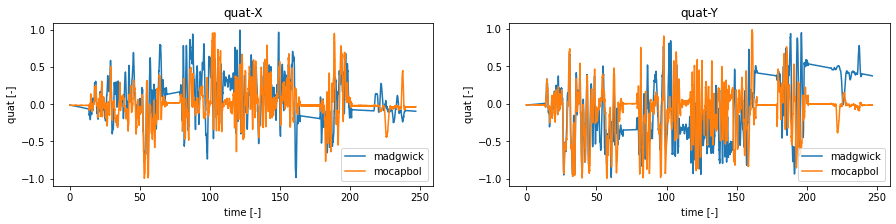

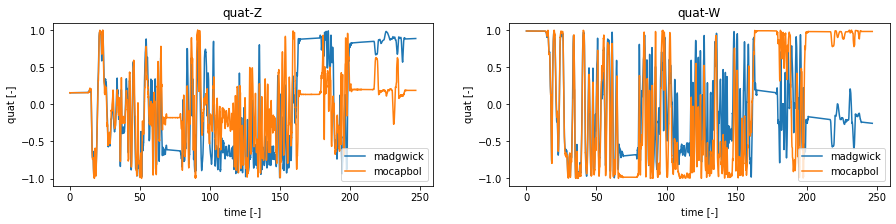

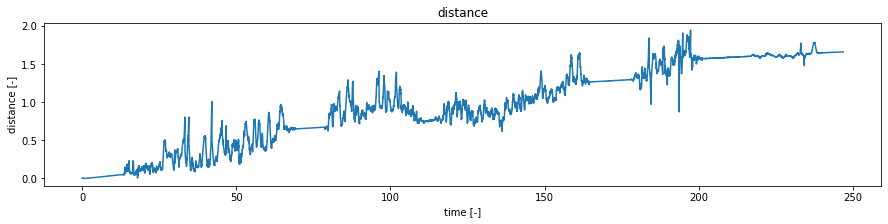

In [29]:
time = np.zeros(len(d.data))
for i in range(len(d.data)):
    time[i] = 0.004*i
    
distance = distance_check(d.data[:,21:25], d.data[:,29:33], plot=False, dlist =True)

plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-X")
plt.plot(time,d.data[:,21],label='madgwick')
plt.plot(time,d.data[:,29],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-Y")
plt.plot(time,d.data[:,22],label='madgwick')
plt.plot(time,d.data[:,30],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-Z")
plt.plot(time,d.data[:,23],label='madgwick')
plt.plot(time,d.data[:,31],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-W")
plt.plot(time,d.data[:,24],label='madgwick')
plt.plot(time,d.data[:,32],label='mocapbol')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()